In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
from nltk import tokenize
from datetime import datetime
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from numba import jit, prange
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.models import SequenceTagger
from flair.data import Sentence
from segtok.segmenter import split_single
from statistics import mean

sid = SentimentIntensityAnalyzer()
classifier = TextClassifier.load("en-sentiment")

2021-04-08 11:08:35,772 loading file C:\Users\Chris\.flair\models\sentiment-en-mix-distillbert_4.pt


In [3]:
# input data
nvidia_df = pd.read_csv("../00_data/nvidia_caption_data_06APR.gz")

In [4]:
# Cleaning step1: fix the issue were the data was appended incorrectly
correct_df = nvidia_df.iloc[0:16268].copy()
incorrect_df = nvidia_df.iloc[16268:].copy()

# relable incoorect columns to be appended back correctly
incorrect_df.rename(
    columns={
        "captionString": "drop",
        "Unnamed: 0": "Index",
        "Unnamed: 0.1": "videoID",
        "videoID": "datePub",
        "datePub": "searchedDate",
        "searchedDate": "VideoTitle",
        "VideoTitle": "channelTitle",
        "channelTitle": "viewCount",
        "viewCount": "likeCount",
        "likeCount": "dislikeCount",
        "dislikeCount": "captionString",
    },
    inplace=True,
)

# drop the exccess column created by AWS appending
incorrect_df = incorrect_df.drop(columns=["drop"])

# relable columns to match the corrected df
correct_df.rename(columns={"Unnamed: 0.1": "Index"}, inplace=True)
correct_df = correct_df.drop(columns=["Unnamed: 0"])

# create new nvida data frame to begin cleaning and working with
nvidia_df_1 = correct_df.append(incorrect_df, sort=False)

# initialize correct types of data for each column
nvidia_df_1["VideoTitle"] = nvidia_df_1["VideoTitle"].astype("str")
nvidia_df_1["datePub"] = pd.to_datetime(
    nvidia_df_1["datePub"], format="%Y-%m-%d %H:%M:%S", utc=True
)
nvidia_df_1["searchedDate"] = pd.to_datetime(
    nvidia_df_1["searchedDate"], format="%Y-%m-%d %H:%M:%S", utc=True
)
nvidia_df_1["channelTitle"] = nvidia_df_1["channelTitle"].astype("str")
nvidia_df_1["viewCount"] = nvidia_df_1["viewCount"].astype("int")
nvidia_df_1["likeCount"] = nvidia_df_1["likeCount"].astype("int")
nvidia_df_1["dislikeCount"] = nvidia_df_1["dislikeCount"].astype("int")
nvidia_df_1["captionString"] = nvidia_df_1["captionString"].astype("str")

# define a cleaning function to clean and standardize caption strings
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("\\[[^][]*]", "", raw)
    result = re.sub("<[a][^>]*>(.+?)</[a]>", "Link.", result)
    result = re.sub("&gt;", "", result)
    result = re.sub("&#x27;", "'", result)
    result = re.sub("&quot;", '"', result)
    result = re.sub("&#x2F;", " ", result)
    result = re.sub("<p>", " ", result)
    result = re.sub("</i>", "", result)
    result = re.sub("&#62;", "", result)
    result = re.sub("<i>", " ", result)
    result = re.sub("\n", "", result)
    result = re.sub("     ", "", result)
    return result


nvidia_df_1["captionString"] = nvidia_df_1["captionString"].apply(clean)
nvidia_df_1["VideoTitle"] = nvidia_df_1["VideoTitle"].apply(clean)

# for i in range(len(nvidia_df_1["captionString"])):
#    nvidia_df_1["captionString"][i] = clean(nvidia_df_1["captionString"][i])

In [7]:
nvidia_df_1.dtypes

Index                                                     object
videoID                                                   object
datePub                                      datetime64[ns, UTC]
searchedDate                                 datetime64[ns, UTC]
VideoTitle                                                object
channelTitle                                              object
viewCount                                                  int32
likeCount                                                  int32
dislikeCount                                               int32
captionString                                             object
num_days_since_pub                                       float64
viewcounts_weighted                                      float64
like_count_weighted                                      float64
dislike_count_weighted                                   float64
like_dislike_ratio                                       float64
weighted_like_dislike_rat

In [6]:
#####
# Metric Features
#####

nvidia_df_1["num_days_since_pub"] = np.ceil(
    (nvidia_df_1["searchedDate"] - nvidia_df_1["datePub"]) / np.timedelta64(1, "D")
)
nvidia_df_1["viewcounts_weighted"] = (
    nvidia_df_1["viewCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["like_count_weighted"] = (
    nvidia_df_1["likeCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["dislike_count_weighted"] = (
    nvidia_df_1["dislikeCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["like_dislike_ratio"] = nvidia_df_1["likeCount"] / (
    nvidia_df_1["likeCount"] + nvidia_df_1["dislikeCount"]
)
nvidia_df_1["weighted_like_dislike_ratio"] = nvidia_df_1["like_count_weighted"] / (
    nvidia_df_1["like_count_weighted"] + nvidia_df_1["dislike_count_weighted"]
)
nvidia_df_1["like_dislike_ratio_by_viewcounts_weighted"] = (
    nvidia_df_1["like_dislike_ratio"] * nvidia_df_1["viewcounts_weighted"]
)
nvidia_df_1["Date"] = pd.to_datetime(
    nvidia_df_1["searchedDate"], format="%Y-%m-%d", utc=True
).dt.date

In [44]:
#####
# Create df with only videos from unique video IDs and run sentiment analysis, then store for re populating
# into the orginal df
#####

sentiment_df = nvidia_df_1.drop_duplicates(subset="videoID")

In [45]:
sentiment_df.columns

Index(['Index', 'videoID', 'datePub', 'searchedDate', 'VideoTitle',
       'channelTitle', 'viewCount', 'likeCount', 'dislikeCount',
       'captionString', 'num_days_since_pub', 'viewcounts_weighted',
       'like_count_weighted', 'dislike_count_weighted', 'like_dislike_ratio',
       'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted', 'Date'],
      dtype='object')

In [46]:
#####
# Drop unuse columns for sentiment analysis
#####

columns_to_drop = [
    "Index",
    "datePub",
    "searchedDate",
    "channelTitle",
    "viewCount",
    "likeCount",
    "dislikeCount",
    "num_days_since_pub",
    "viewcounts_weighted",
    "like_count_weighted",
    "dislike_count_weighted",
    "like_dislike_ratio",
    "weighted_like_dislike_ratio",
    "like_dislike_ratio_by_viewcounts_weighted",
    "Date",
]

sentiment_df = sentiment_df.drop(columns_to_drop, axis=1)

sentiment_df_1 = sentiment_df.copy()

In [47]:
sentiment_df_1

,videoID,VideoTitle,captionString
0,y4fb_R5Ogw0,"2x NVIDIA RTX 3090 SLI Benchmarks: 500FPS, 700...",so this setup that you're seeing is what we ha...
1,ALEXVtnNEwA,NVIDIA GeForce Special Event Livestream,b welcome to my kitchen i hope all of you are ...
2,E98hC9e__Xs,NVIDIA GeForce RTX 30 Series | Official Launch...,Welcome to my kitchen. I hope all of you are...
3,nMns8t4OhI0,NVIDIA Responds to RTX 3080 Crashes...,
4,AG_ZHi3tuyk,"Nvidia, you PROMISED! - RTX 3080 Review",- The RTX 3080 is the most powerful GPU we've ...
...,...,...,...
22771,sb1yB4j6W7Q,NVIDIA RTX RESIZABLE BAR/SAM - ЗРЯ ЖДАЛИ?! ОЦЕ...,
22775,-1mrb5YH4ng,"HW News - DDR5 512GB Sticks, Secret NVIDIA ""30...",hey everyone welcome back to another hardware ...
22815,DYXa8M5dGog,GUIA COMPLETO PAINEL DE CONTROLE NVIDIA EM 202...,
22871,rCWTiM7r13E,"В Nvidia сделали RTX Voice для всех, первая мо...",


In [48]:
#####
# conduct previous version of sentiment analysis with vader on full title and caption data
#####

sentiment_df_1["videoTitleSentimentScore_vader_pos"] = [
    sid.polarity_scores(x)["pos"] for x in sentiment_df_1["VideoTitle"]
]

sentiment_df_1["videoTitleSentimentScore_vader_neg"] = [
    sid.polarity_scores(x)["neg"] for x in sentiment_df_1["VideoTitle"]
]

sentiment_df_1["videoTitleSentimentScore_vader_com"] = [
    sid.polarity_scores(x)["compound"] for x in sentiment_df_1["VideoTitle"]
]

sentiment_df_1["captionSentimentScore_vader_pos"] = [
    sid.polarity_scores(x)["pos"] for x in sentiment_df_1["captionString"]
]

sentiment_df_1["captionSentimentScore_vader_neg"] = [
    sid.polarity_scores(x)["neg"] for x in sentiment_df_1["captionString"]
]

sentiment_df_1["captionSentimentScore_vader_com"] = [
    sid.polarity_scores(x)["compound"] for x in sentiment_df_1["captionString"]
]

In [49]:
#####
# conduct new version of sentiment analysis with vader on full title and segmented caption data
#####

# Build funsitons that will parse through captions and return strings borken up by the key work, nvida, and preceding and post words

classifier = TextClassifier.load("en-sentiment")

# utilize regular expressions to split large stings into sentences that are centered around the key words


def search(target, text, context=6):
    # It's easier to use re.findall to split the string,
    # as we get rid of the punctuation
    words = re.findall(r"\w+", text)

    matches = (i for (i, w) in enumerate(words) if w.lower() == target)
    for index in matches:
        if index < context // 2:
            yield words[0 : context + 1]
        elif index > len(words) - context // 2 - 1:
            yield words[-(context + 1) :]
        else:
            yield words[index - context // 2 : index + context // 2 + 1]


def flair_predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()["value"]
    if value == "POSITIVE":
        result = text.to_dict()["labels"][0]["confidence"]
    else:
        result = -(text.to_dict()["labels"][0]["confidence"])
    return round(result, 3)


def vader_predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    # stacked_embeddings.embed(text)
    else:
        score = sid.polarity_scores(" ".join(sentence))
        result = score["pos"]
        return round(result, 3)


def get_scores(sentences, flairPredict=True):
    """ Call predict on every sentence of a text """
    results = []

    if flairPredict == True:
        for i in range(0, len(sentences)):
            results.append(flair_predict(sentences[i]))
        return results
    else:
        for i in range(0, len(sentences)):
            results.append(vader_predict(sentences[i]))
        return results


def get_scores_single_cap(sentences, flairPredict=True):
    """ Call predict on single caption string """
    if flairPredict == True:
        results = []
        results.append(flair_predict(sentences))
        return results
    else:
        results = []
        results.append(vader_predict(sentences))
        return results


def get_sum(scores):
    result = round(sum(scores), 3)
    return result


def get_avg(scores):
    if len(scores) == 0:
        return 0
    else:
        result = round((sum(scores) / len(scores)), 3)
        return result

2021-04-08 12:37:24,676 loading file C:\Users\Chris\.flair\models\sentiment-en-mix-distillbert_4.pt


In [50]:
# Build the new sentences that will be used for sentiment analysis

sentiment_df_1["caption_list_split_by_nvidia_10words"] = [
    list(search("nvidia", x, 10)) for x in sentiment_df_1["captionString"]
]

sentiment_df_1["caption_list_split_by_nvidia_20words"] = [
    list(search("nvidia", x, 20)) for x in sentiment_df_1["captionString"]
]

sentiment_df_1["caption_list_split_by_nvidia_35words"] = [
    list(search("nvidia", x, 35)) for x in sentiment_df_1["captionString"]
]

In [56]:
sentiment_df_1["falir_videoTitle_score"] = [
    get_scores_single_cap(x, flairPredict=True) for x in sentiment_df_1["VideoTitle"]
]

sentiment_df_1["caption_list_split_by_nvidia_10words_flairscores"] = [
    get_avg(get_scores(x, flairPredict=True))
    for x in sentiment_df_1["caption_list_split_by_nvidia_10words"]
]

sentiment_df_1["caption_list_split_by_nvidia_20words_flairscores"] = [
    get_avg(get_scores(x, flairPredict=True))
    for x in sentiment_df_1["caption_list_split_by_nvidia_20words"]
]

sentiment_df_1["caption_list_split_by_nvidia_35words_flairscores"] = [
    get_avg(get_scores(x, flairPredict=True))
    for x in sentiment_df_1["caption_list_split_by_nvidia_35words"]
]

In [59]:
sentiment_df_1["caption_list_split_by_nvidia_10words_vaderscores"] = [
    get_avg(get_scores(x, flairPredict=False))
    for x in sentiment_df_1["caption_list_split_by_nvidia_10words"]
]

sentiment_df_1["caption_list_split_by_nvidia_20words_vaderscores"] = [
    get_avg(get_scores(x, flairPredict=False))
    for x in sentiment_df_1["caption_list_split_by_nvidia_20words"]
]

sentiment_df_1["caption_list_split_by_nvidia_35words_vaderscores"] = [
    get_avg(get_scores(x, flairPredict=False))
    for x in sentiment_df_1["caption_list_split_by_nvidia_35words"]
]

In [60]:
sentiment_df_1

,videoID,VideoTitle,captionString,videoTitleSentimentScore_vader_pos,videoTitleSentimentScore_vader_neg,videoTitleSentimentScore_vader_com,captionSentimentScore_vader_pos,captionSentimentScore_vader_neg,captionSentimentScore_vader_com,caption_list_split_by_nvidia_10words,caption_list_split_by_nvidia_20words,caption_list_split_by_nvidia_35words,falir_videoTitle_score,caption_list_split_by_nvidia_10words_flairscores,caption_list_split_by_nvidia_20words_flairscores,caption_list_split_by_nvidia_35words_flairscores,caption_list_split_by_nvidia_10words_vaderscores,caption_list_split_by_nvidia_20words_vaderscores,caption_list_split_by_nvidia_35words_vaderscores
0,y4fb_R5Ogw0,"2x NVIDIA RTX 3090 SLI Benchmarks: 500FPS, 700...",so this setup that you're seeing is what we ha...,0.214,0.151,0.2023,0.124,0.067,0.9997,"[[more, strict, than, ever, as, nvidia, has, o...","[[for, sli, these, days, are, more, strict, th...","[[on, the, board, and, also, the, limitations,...",[-0.997],-0.210,-0.566,-0.577,0.097,0.065,0.077
1,ALEXVtnNEwA,NVIDIA GeForce Special Event Livestream,b welcome to my kitchen i hope all of you are ...,0.403,0.000,0.4019,0.145,0.027,1.0000,"[[incredibly, in, the, time, of, nvidia, as, t...","[[graphics, and, have, advanced, it, incredibl...","[[to, push, the, boundaries, we, love, compute...",[0.999],0.623,0.736,0.649,0.110,0.113,0.122
2,E98hC9e__Xs,NVIDIA GeForce RTX 30 Series | Official Launch...,Welcome to my kitchen. I hope all of you are...,0.000,0.000,0.0000,0.133,0.025,1.0000,"[[incredibly, in, the, time, of, NVIDIA, As, t...","[[graphics, and, have, advanced, it, incredibl...","[[to, push, the, boundaries, We, love, compute...",[0.998],0.621,0.663,0.716,0.104,0.110,0.114
3,nMns8t4OhI0,NVIDIA Responds to RTX 3080 Crashes...,,0.000,0.000,0.0000,0.000,0.000,0.0000,[],[],[],[-0.996],0.000,0.000,0.000,0.000,0.000,0.000
4,AG_ZHi3tuyk,"Nvidia, you PROMISED! - RTX 3080 Review",- The RTX 3080 is the most powerful GPU we've ...,0.413,0.000,0.5461,0.140,0.043,0.9997,"[[this, off, of, my, chest, NVIDIA, man, you, ...","[[test, platform, let, me, get, this, off, of,...","[[rattling, Weird, While, you, read, over, our...",[0.998],0.196,0.146,-0.017,0.084,0.077,0.086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22771,sb1yB4j6W7Q,NVIDIA RTX RESIZABLE BAR/SAM - ЗРЯ ЖДАЛИ?! ОЦЕ...,,0.000,0.000,0.0000,0.000,0.000,0.0000,[],[],[],[0.609],0.000,0.000,0.000,0.000,0.000,0.000
22775,-1mrb5YH4ng,"HW News - DDR5 512GB Sticks, Secret NVIDIA ""30...",hey everyone welcome back to another hardware ...,0.000,0.000,0.0000,0.085,0.043,0.9996,"[[ll, also, be, talking, about, nvidia, changi...","[[dimms, kind, of, insane, we, ll, also, be, t...","[[where, samsung, is, looking, at, 512, gigaby...",[-0.915],-0.334,-0.413,-0.762,0.000,0.014,0.024
22815,DYXa8M5dGog,GUIA COMPLETO PAINEL DE CONTROLE NVIDIA EM 202...,,0.000,0.000,0.0000,0.000,0.000,0.0000,[],[],[],[0.973],0.000,0.000,0.000,0.000,0.000,0.000
22871,rCWTiM7r13E,"В Nvidia сделали RTX Voice для всех, первая мо...",,0.218,0.000,0.5994,0.000,0.000,0.0000,[],[],[],[0.996],0.000,0.000,0.000,0.000,0.000,0.000


In [61]:
nvidia_df_1

,Index,videoID,datePub,searchedDate,VideoTitle,channelTitle,viewCount,likeCount,dislikeCount,captionString,num_days_since_pub,viewcounts_weighted,like_count_weighted,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,Date
0,0,y4fb_R5Ogw0,2020-10-01 05:16:02+00:00,2020-10-02 01:45:21.553469+00:00,"2x NVIDIA RTX 3090 SLI Benchmarks: 500FPS, 700...",Gamers Nexus,367472,15701,260,so this setup that you're seeing is what we ha...,1.0,367472.000000,15701.000000,260.000000,0.983710,0.983710,361485.989098,2020-10-02
1,1,ALEXVtnNEwA,2020-09-01 17:15:57+00:00,2020-10-02 01:45:22.351801+00:00,NVIDIA GeForce Special Event Livestream,IGN,543115,16860,411,b welcome to my kitchen i hope all of you are ...,31.0,17519.838710,543.870968,13.258065,0.976203,0.976203,17102.917066,2020-10-02
2,2,E98hC9e__Xs,2020-09-01 16:42:07+00:00,2020-10-02 01:45:23.252012+00:00,NVIDIA GeForce RTX 30 Series | Official Launch...,NVIDIA GeForce,1484075,54741,1135,Welcome to my kitchen. I hope all of you are...,31.0,47873.387097,1765.838710,36.612903,0.979687,0.979687,46900.942857,2020-10-02
3,3,nMns8t4OhI0,2020-09-30 23:00:06+00:00,2020-10-02 01:45:23.922084+00:00,NVIDIA Responds to RTX 3080 Crashes...,JayzTwoCents,561238,27766,885,,2.0,280619.000000,13883.000000,442.500000,0.969111,0.969111,271950.966947,2020-10-02
4,4,AG_ZHi3tuyk,2020-09-16 12:59:59+00:00,2020-10-02 01:45:24.592244+00:00,"Nvidia, you PROMISED! - RTX 3080 Review",Linus Tech Tips,3391565,141852,3961,- The RTX 3080 is the most powerful GPU we've ...,16.0,211972.812500,8865.750000,247.562500,0.972835,0.972835,206214.585797,2020-10-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22913,20,O4kkTlIMDzU,2021-04-06 11:00:13+00:00,2021-04-06 19:00:46.802540+00:00,"Nvidia REVIVE sus GTX serie 10, ADIÓS Yahoo Re...",DrogaDigital,17280,1889,31,,1.0,17280.000000,1889.000000,31.000000,0.983854,0.983854,17001.000000,2021-04-06
22914,21,mjjhe592OHg,2021-03-31 14:00:30+00:00,2021-04-06 19:00:47.315199+00:00,Nvidia Did The Unexpected,Hot News,25437,1746,35,and video pulls a move that is good for the co...,7.0,3633.857143,249.428571,5.000000,0.980348,0.980348,3562.445015,2021-04-06
22915,22,iXn9O-Rzb_M,2020-12-12 03:10:26+00:00,2021-04-06 19:00:48.018268+00:00,NVIDIA might ACTUALLY be EVIL... - WAN Show De...,Linus Tech Tips,1711614,100636,1806,,116.0,14755.293103,867.551724,15.568966,0.982371,0.982371,14495.164842,2021-04-06
22916,23,MrcNkPOX77U,2021-01-12 17:32:50+00:00,2021-04-06 19:00:48.632900+00:00,NVIDIA GeForce RTX: Game On Livestream - CES 2021,GameTrailers,11636,277,40,is go magic me is uh and i'm gett...,85.0,136.894118,3.258824,0.470588,0.873817,0.873817,119.620412,2021-04-06


In [67]:
print(f"The shape of nvidia_df_1 is: {nvidia_df_1.shape}")
print(f"The shape of sentiment_df_1 is: {sentiment_df_1.shape}")

The shape of nvidia_df_1 is: (22918, 18)
The shape of sentiment_df_1 is: (500, 19)


In [94]:
#####
# Merge the df's to add sentiment analysis back in
#####

sentiment_final_df = nvidia_df_1.merge(
    sentiment_df_1, how="outer", on="videoID"
).sort_values(by=["searchedDate"])

In [83]:
#####
# save df without aggrigating down to an hour
#####

sentiment_final_df.to_csv(
    "../00_data/feature_aggrigated_flairvader_08APR_NOT_BY_HOUR.gz", compression="gzip"
)

In [91]:
sentiment_final_df.columns

Index(['Index', 'videoID', 'datePub', 'searchedDate', 'VideoTitle_x',
       'channelTitle', 'viewCount', 'likeCount', 'dislikeCount',
       'captionString_x', 'num_days_since_pub', 'viewcounts_weighted',
       'like_count_weighted', 'dislike_count_weighted', 'like_dislike_ratio',
       'weighted_like_dislike_ratio',
       'like_dislike_ratio_by_viewcounts_weighted', 'Date',
       'videoTitleSentimentScore_vader_pos',
       'videoTitleSentimentScore_vader_neg',
       'videoTitleSentimentScore_vader_com', 'captionSentimentScore_vader_pos',
       'captionSentimentScore_vader_neg', 'captionSentimentScore_vader_com',
       'caption_list_split_by_nvidia_10words',
       'caption_list_split_by_nvidia_20words',
       'caption_list_split_by_nvidia_35words', 'falir_videoTitle_score',
       'caption_list_split_by_nvidia_10words_flairscores',
       'caption_list_split_by_nvidia_20words_flairscores',
       'caption_list_split_by_nvidia_35words_flairscores',
       'caption_list_split_

In [95]:
sentiment_final_df = sentiment_final_df.drop(
    columns=["VideoTitle_y", "captionString_y"]
)

sentiment_final_df.rename(
    columns={"VideoTitle_x": "VideoTitle", "captionString_x": "captionString"},
    inplace=True,
)

In [111]:
#####
# replace all 0's for sentiment analysis with nan's
#####

sentiment_final_df.iloc[:, 18:24] = sentiment_final_df.iloc[:, 18:24].replace(0, np.NaN)
sentiment_final_df.iloc[:, 27:] = sentiment_final_df.iloc[:, 27:].replace(0, np.NaN)

In [114]:
X_feautures_pre_merge_1 = sentiment_final_df.copy()

# X_feautures_pre_merge["Date"] = pd.to_datetime(
#     X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
# ).dt.date

pre_nan_drop_X_feautures_pre_merge = X_feautures_pre_merge_1.groupby(
    pd.Grouper(key="searchedDate", freq="H", offset="30min")
).mean()

post_nan_drop_X_feautures_post_merge = pre_nan_drop_X_feautures_pre_merge[
    pre_nan_drop_X_feautures_pre_merge["viewCount"].notna()
]

In [115]:
post_nan_drop_X_feautures_post_merge

,viewCount,likeCount,dislikeCount,num_days_since_pub,viewcounts_weighted,like_count_weighted,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,...,videoTitleSentimentScore_vader_com,captionSentimentScore_vader_pos,captionSentimentScore_vader_neg,captionSentimentScore_vader_com,caption_list_split_by_nvidia_10words_flairscores,caption_list_split_by_nvidia_20words_flairscores,caption_list_split_by_nvidia_35words_flairscores,caption_list_split_by_nvidia_10words_vaderscores,caption_list_split_by_nvidia_20words_vaderscores,caption_list_split_by_nvidia_35words_vaderscores
searchedDate,,,,,,,,,,,,,,,,,,,,,
2020-10-02 01:30:00+00:00,1.750508e+06,69801.600000,1799.700000,16.600000,137832.492033,5912.089949,150.234402,0.973936,0.973936,134451.295653,...,0.064480,0.125125,0.046500,0.935225,0.280500,0.068875,0.009250,0.086429,0.091625,0.100000
2020-10-02 16:30:00+00:00,9.644912e+05,40463.448276,1070.793103,15.241379,84589.429291,3723.437055,97.624292,0.971347,0.971347,82587.974284,...,-0.014347,0.122280,0.046480,0.998404,0.069875,-0.045000,-0.159125,0.099091,0.093435,0.096708
2020-10-02 17:30:00+00:00,1.045160e+06,44341.740000,1192.020000,17.400000,63909.437389,2967.019734,89.903678,0.969618,0.969618,62169.305249,...,-0.081008,0.121952,0.042571,0.998157,0.125850,0.059200,-0.075550,0.099556,0.099421,0.100650
2020-10-02 18:30:00+00:00,1.077168e+06,46144.080000,1244.080000,18.640000,64870.463707,3002.939559,91.268385,0.967561,0.967561,63097.778622,...,-0.004042,0.120857,0.039333,0.998038,0.166950,0.157000,-0.018450,0.096176,0.097526,0.098400
2020-10-02 19:30:00+00:00,1.077747e+06,46178.200000,1245.080000,18.680000,65211.201800,3031.484044,92.005868,0.969667,0.969667,63429.337457,...,-0.082817,0.121143,0.042048,0.998081,0.090150,0.092750,-0.072100,0.096667,0.098474,0.098000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-06 02:30:00+00:00,9.685248e+05,51622.120000,1147.000000,124.560000,25124.394958,1578.261138,31.856300,0.963919,0.963919,24581.386057,...,-0.027650,0.143000,0.040412,0.996694,-0.035941,0.107412,-0.021471,0.111467,0.106059,0.111941
2021-04-06 05:30:00+00:00,9.536512e+05,50419.400000,1147.080000,118.560000,25104.699517,1556.861739,32.493516,0.954387,0.954387,24536.377196,...,-0.061050,0.126632,0.038895,0.999153,0.041368,0.200895,0.085579,0.108471,0.108737,0.113947
2021-04-06 10:30:00+00:00,9.579433e+05,50762.600000,1150.440000,119.200000,24697.948456,1518.168953,31.140780,0.955898,0.955898,24154.344992,...,-0.008650,0.127316,0.039526,0.999179,0.046526,0.165316,0.083368,0.105647,0.102053,0.108895


In [116]:
post_nan_drop_X_feautures_post_merge.to_csv(
    "../00_data/By_hour_feature_aggrigated_flairvader_08APR.gz", compression="gzip"
)

#### Appendix / Prior UnOptimized Code

In [ ]:
sid = SentimentIntensityAnalyzer()

# nvidia_df_1["videoTitleSentimentScore_vader_pos"] = [
#     sid.polarity_scores(x)["pos"] for x in nvidia_df_1["VideoTitle"]
# ]

# nvidia_df_1["videoTitleSentimentScore_vader_neg"] = [
#     sid.polarity_scores(x)["neg"] for x in nvidia_df_1["VideoTitle"]
# ]

# nvidia_df_1["captionSentimentScore_vader_pos"] = [
#     sid.polarity_scores(x)["pos"] for x in nvidia_df_1["captionString"]
# ]

# nvidia_df_1["captionSentimentScore_vader_neg"] = [
#     sid.polarity_scores(x)["neg"] for x in nvidia_df_1["captionString"]
# ]

# nvidia_df_1["captionSentimentScore_vader_com"] = [
#     sid.polarity_scores(x)["compound"] for x in nvidia_df_1["captionString"]
# ]

# nvidia_df_1["videoTitleSentimentScore_vader_com"] = [
#     sid.polarity_scores(x)["compound"] for x in nvidia_df_1["VideoTitle"]
# ]


#####
# Create one socre a cycle through to pullout late to aave on speed
#####

nvidia_df_1["videoTitleSentimentScore_vader_scores"] = [
    sid.polarity_scores(x) for x in nvidia_df_1["VideoTitle"]
]

nvidia_df_1["videoTitleSentimentScore_caption_scores"] = [
    sid.polarity_scores(x) for x in nvidia_df_1["captionString"]
]

In [7]:
classifier = TextClassifier.load("en-sentiment")

# utilize regular expressions to split large stings into sentences that are centered around the key words


def search(target, text, context=6):
    # It's easier to use re.findall to split the string,
    # as we get rid of the punctuation
    words = re.findall(r"\w+", text)

    matches = (i for (i, w) in enumerate(words) if w.lower() == target)
    for index in matches:
        if index < context // 2:
            yield words[0 : context + 1]
        elif index > len(words) - context // 2 - 1:
            yield words[-(context + 1) :]
        else:
            yield words[index - context // 2 : index + context // 2 + 1]


def flair_predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()["value"]
    if value == "POSITIVE":
        result = text.to_dict()["labels"][0]["confidence"]
    else:
        result = -(text.to_dict()["labels"][0]["confidence"])
    return round(result, 3)


def vader_predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    # stacked_embeddings.embed(text)
    else:
        score = sid.polarity_scores(" ".join(sentence))
        result = score["pos"]
        return round(result, 3)


def get_scores(sentences, flairPredict=True):
    """ Call predict on every sentence of a text """
    results = []

    if flairPredict == True:
        for i in range(0, len(sentences)):
            results.append(flair_predict(sentences[i]))
        return results
    else:
        for i in range(0, len(sentences)):
            results.append(vader_predict(sentences[i]))
        return results


def get_scores_single_cap(sentences, flairPredict=True):
    """ Call predict on single caption string """
    if flairPredict == True:
        results = []
        results.append(flair_predict(sentences))
        return results
    else:
        results = []
        results.append(vader_predict(sentences))
        return results


def get_sum(scores):
    result = round(sum(scores), 3)
    return result


def get_avg(scores):
    if len(scores) == 0:
        return 0
    else:
        result = round((sum(scores) / len(scores)), 3)
        return result

2021-04-08 07:59:20,248 loading file C:\Users\Chris\.flair\models\sentiment-en-mix-distillbert_4.pt


In [8]:
nvidia_df_1["caption_list_split_by_nvidia_10words"] = [
    list(search("nvidia", x, 10)) for x in nvidia_df_1["captionString"]
]

nvidia_df_1["caption_list_split_by_nvidia_20words"] = [
    list(search("nvidia", x, 20)) for x in nvidia_df_1["captionString"]
]

nvidia_df_1["caption_list_split_by_nvidia_35words"] = [
    list(search("nvidia", x, 35)) for x in nvidia_df_1["captionString"]
]

In [ ]:
nvidia_df_1

In [ ]:
nvidia_df_1["caption_list_split_by_nvidia_10words_flairscores"] = [
    get_scores(x, flairPredict = True) for x in nvidia_df_1["caption_list_split_by_nvidia_10words"]
]

nvidia_df_1["caption_list_split_by_nvidia_20words_flairscores"] = [
    get_avg(get_scores(x, flairPredict = True)) for x in nvidia_df_1["caption_list_split_by_nvidia_20words"]
]

nvidia_df_1["caption_list_split_by_nvidia_35words_flairscores"] = [
    get_avg(get_scores(x, flairPredict = True)) for x in nvidia_df_1["caption_list_split_by_nvidia_35words"]
]

In [ ]:
#### Not needed anymore

# nvidia_df_1["caption_list_split_by_nvidia_10words_flairAvgScore"] = [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_10words_flairscores"]
# ]

# nvidia_df_1["caption_list_split_by_nvidia_20words_flairAvgScore"] = [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_20words_flairscores"]
# ]
    
# nvidia_df_1["caption_list_split_by_nvidia_35words_flairAvgScore"] = [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_35words_flairscores"]
# ]

In [ ]:
nvidia_df_1["caption_list_split_by_nvidia_10words_vaderscores"] = [
    get_avg(get_scores(x, vaderPredict = False)) for x in nvidia_df_1["caption_list_split_by_nvidia_10words"]
]

# nvidia_df_1["caption_list_split_by_nvidia_10words_vaderAvgScore"] = 
# [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_10words_vaderscores"]
# ]

nvidia_df_1["caption_list_split_by_nvidia_20words_vaderscores"] = [
    get_avg(get_scores(x, vaderPredict = False)) for x in nvidia_df_1["caption_list_split_by_nvidia_20words"]
]

# nvidia_df_1["caption_list_split_by_nvidia_20words_vaderAvgScore"] = 
# [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_20words_vaderscores"]
# ]

nvidia_df_1["caption_list_split_by_nvidia_35words_vaderscores"] = [
    get_avg(get_scores(x, vaderPredict = False)) for x in nvidia_df_1["caption_list_split_by_nvidia_35words"]
]

# nvidia_df_1["caption_list_split_by_nvidia_35words_vaderAvgScore"] = 
# [
#     get_avg(x) for x in nvidia_df_1["caption_list_split_by_nvidia_35words_vaderscores"]
# ]

In [ ]:
nvidia_df_1["num_days_since_pub"] = np.ceil(
    (nvidia_df_1["searchedDate"] - nvidia_df_1["datePub"]) / np.timedelta64(1, "D")
)
nvidia_df_1["viewcounts_weighted"] = (
    nvidia_df_1["viewCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["like_count_weighted"] = (
    nvidia_df_1["likeCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["dislike_count_weighted"] = (
    nvidia_df_1["dislikeCount"] / nvidia_df_1["num_days_since_pub"]
)
nvidia_df_1["like_dislike_ratio"] = nvidia_df_1["likeCount"] / (
    nvidia_df_1["likeCount"] + nvidia_df_1["dislikeCount"]
)
nvidia_df_1["weighted_like_dislike_ratio"] = nvidia_df_1["like_count_weighted"] / (
    nvidia_df_1["like_count_weighted"] + nvidia_df_1["dislike_count_weighted"]
)
nvidia_df_1["like_dislike_ratio_by_viewcounts_weighted"] = (
    nvidia_df_1["like_dislike_ratio"] * nvidia_df_1["viewcounts_weighted"]
)
nvidia_df_1["Date"] = pd.to_datetime(
    nvidia_df_1["searchedDate"], format="%Y-%m-%d", utc=True
).dt.date

### X_feautures_pre_merge

In [ ]:
X_feautures_pre_merge = nvidia_df_1.copy()

# X_feautures_pre_merge["Date"] = pd.to_datetime(
#     X_feautures_pre_merge["Date"], format="%Y-%m-%d", utc=True
# ).dt.date

pre_nan_drop_X_feautures_pre_merge = X_feautures_pre_merge_1.groupby(pd.Grouper(key="searchedDate", freq='H', offset = "30min")).mean()

post_nan_drop_X_feautures_post_merge = pre_nan_drop_X_feautures_pre_merge [pre_nan_drop_X_feautures_pre_merge ['viewCount'].notna()]

In [ ]:
post_nan_drop_X_feautures_post_merge

In [ ]:
post_nan_drop_X_feautures_post_merge.to_csv("../00_data/By_hour_feature_aggrigated_flairvader_06APR.gz", compression = "gzip")

### Plot number of vidoes per day

In [ ]:
nvidia_df_2 = nvidia_df_1.copy()
nvidia_df_2["VideoTitle"] = nvidia_df_2["VideoTitle"].apply(clean)

In [8]:
data_df = pd.to_datetime(
    nvidia_df_2["searchedDate"], format="%Y-%m-%d", utc=True
).dt.date

In [9]:
data_df.value_counts()

2020-10-26    335
2020-11-20    325
2020-10-29    309
2020-10-07    300
2021-02-19    300
             ... 
2021-01-07     25
2020-12-15     25
2020-12-12     25
2020-12-21     25
2021-01-04     25
Name: searchedDate, Length: 136, dtype: int64

In [10]:
type(nvidia_df["searchedDate"][0])

str

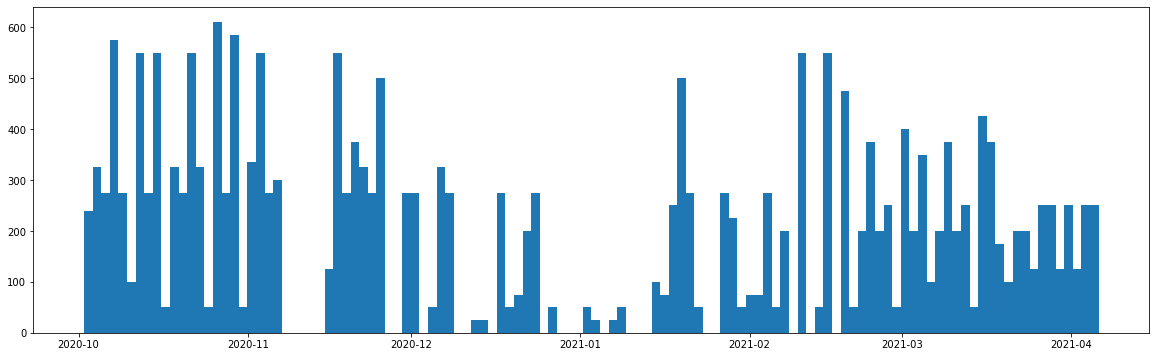

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.hist(
    (pd.to_datetime(nvidia_df_2["searchedDate"], format="%Y-%m-%d", utc=True).dt.date),
    bins=118,
)

plt.show()